<a href="https://colab.research.google.com/github/nishvit/DNN/blob/master/Session_7_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, Input, DepthwiseConv2D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import layers, models

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

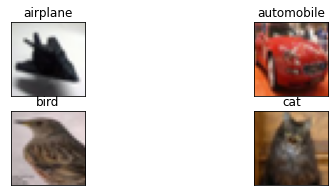

In [3]:
class_names = ['airplane','automobile','bird','cat']
for_heatmap_plot = dict ()
fig = plt.figure(figsize=(8,3))
for i in range(4):
    ax = fig.add_subplot(2, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    im = features_idx[i]
    ax.set_title(class_names[i])
    for_heatmap_plot[ class_names[i] ] = train_features[idx]
    plt.imshow(im)
plt.show()

In [4]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [5]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [6]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)
cardinality = 32


In [ ]:
from keras import layers

#define global parameters
img_width = 32
img_height = 32
img_channels = 3

def assignment_7B (x):
  
  def add_common_layers (y):
    y = layers.BatchNormalization ()(y)
    y = layers.Activation ('relu')(y)
    return y
  
  def concat (y):
    y = layers.concatenate (y)
    y = add_common_layers (y)
    return y

  def sep (y, channel_size, kernel_size, history, count):
    y = layers.SeparableConv2D(channel_size, (kernel_size, kernel_size), padding='same', use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(y)
    y = add_common_layers (y)
    #index = 0
    history.append (y)
    count += 1
    return (y, history, count)
  
  def conv (y, channel_size, kernel_size, history, count):
    y = layers.Conv2D (channel_size, (kernel_size, kernel_size), strides = (1, 1), padding = 'same')(y)
    y = add_common_layers (y)
    #index = 0
    history.append (y)
    count += 1
    return (y, history, count)
    
  
  history = []
  count = -1
  
  #part 1
  (x, history, count) = sep (x, 48, 5, history, count)

  #part 2
  (x, history, count) = conv (x, 48, 5, history, count)

  #part 3
  (x, history, count) = conv (x, 48, 5, history, count)

  #part 4
  (x, history, count) = sep (concat ([x, history[0]]), 48, 5, history, count)
  
  #part 5
  x = layers.MaxPooling2D((2, 2))(concat ([x, history[0]]))
  x = add_common_layers (x)
  history.append (x)

  #part 6
  (x, history, count) = sep (x, 48, 3, history, count)

  #part 7
  #(x, history, count) = conv (x, 48, 5, history, count)
  (x, history, count) = conv (x, 48, 5, history, count)

  #part 8
  (x, history, count) = sep (x, 48, 3, history, count)

  #part 9
  (x, history, count) = sep (x, 48, 5, history, count)
  
  #part 10
  x = layers.MaxPooling2D((2, 2))(concat ([x,history[5]]))
  x = add_common_layers (x)
  history.append (x)

  #part 11
  (x, history, count) = conv (x, 48, 5, history, count)

  #part 12
  (x, history, count) = sep (x, 48, 5, history, count)

  #part 13
  (x, history, count) = conv (x, 48, 5, history, count)

  #part 14
  (x, history, count) = sep (x, 48, 5, history, count)
  
  #part 15 
  x = layers.Conv2D (10, (8, 8))(concat ([x, layers.Reshape((8,8,48*16))(history[3]),history[11]]))
  x = add_common_layers (x)
  x = layers.Flatten()(x)
  x = layers.Activation ('softmax')(x)
  history.append (x)
  
  for i, element in enumerate (history):
    print (i, element.shape)
  return x

image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = assignment_7B (image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Epoch 1/5
1563/1563 [==============================] - 35s 23ms/step - loss: 1.3889 - accuracy: 0.5443 - val_loss: 1.1089 - val_accuracy: 0.6371
Epoch 2/5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9687 - accuracy: 0.6820 - val_loss: 0.9498 - val_accuracy: 0.6831
Epoch 3/5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.7753 - accuracy: 0.7448 - val_loss: 0.8156 - val_accuracy: 0.7234
Epoch 4/5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.6440 - accuracy: 0.7895 - val_loss: 0.7781 - val_accuracy: 0.7470
Epoch 5/5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.5220 - accuracy: 0.8307 - val_loss: 0.8377 - val_accuracy: 0.7301
Model took 175.52 seconds to train


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


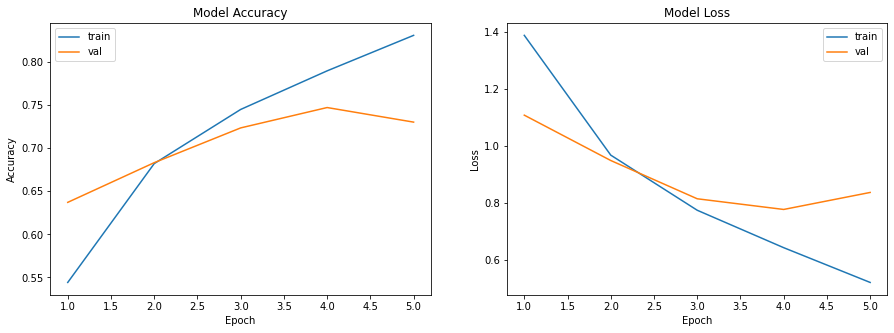

Accuracy on test data is: 73.01


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit(datagen.flow(train_features, train_labels, batch_size = 32),
                                 steps_per_epoch = None, epochs = 5, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.6163 - accuracy: 0.7937 - val_loss: 0.7712 - val_accuracy: 0.7485
Epoch 2/5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.5370 - accuracy: 0.8214 - val_loss: 0.7592 - val_accuracy: 0.7513
Epoch 3/5
1563/1563 [==============================] - 35s 22ms/step - loss: 0.4717 - accuracy: 0.8444 - val_loss: 0.8445 - val_accuracy: 0.7338
Epoch 4/5
1563/1563 [==============================] - 35s 22ms/step - loss: 0.4200 - accuracy: 0.8623 - val_loss: 1.0460 - val_accuracy: 0.6941
Epoch 5/5
1563/1563 [==============================] - 35s 22ms/step - loss: 0.3744 - accuracy: 0.8783 - val_loss: 0.9033 - val_accuracy: 0.7287
Model took 172.63 seconds to train


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


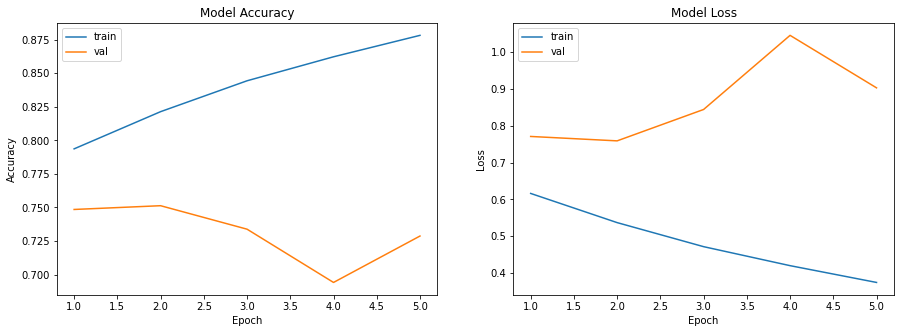

Accuracy on test data is: 72.87


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model.fit(datagen.flow(train_features, train_labels, batch_size = 32),
                                 steps_per_epoch = None, epochs = 5, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))